# ACSE4 2020 Machine Learning Mini-project ------- X-Ray Classification 
<hr>

## Group : MaxPool


# Getting Started

You will need to register for a Google Account (Make a throwaway account if you do not want google to have your data).  

Register on the Kaggle Platform (required for Mini-Project): [Link](https://www.kaggle.com)


# Data gathering

You can use google drive to store and access files, e.g the photo data, model data or CSV files.  
Use the following command to mount your GDrive and access your files.

The dataset was downloaded from Kaggle (https://www.kaggle.com/c/acse4-ml-2020/data) where it was already divided into two initial sets in xray-data folders (train , test). The train folder contain four sub-folders(covid, lung_opacity,normal and pneumonia) where the X-ray images have been already labeled. The test folder only has images without labels

At first, we don't know how many x-rays images have been allocated per set/folder, therefore, the first thing to do is to set up the location of the main directory so that these images can be accessed, followed by a quick review of it's content, meaning how many images have been allocated in each sub-set/folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Using the GPU

Google Colab enables us to obtain free GPU computing resources.  
You can switch the runtime of Google Colab from CPU to GPU based via the ```toolbar```:  

Commands:
```Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU```

In [ ]:
import torch
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Download data 

You could download the data by hand on [Link](https://www.kaggle.com/c/acse4-ml-2020/data), or using the following method to directly grab the data from Kaggle to Google Drive.


### Upload `kaggle.json`, and authorization

Generate a kaggle api from your Kaggle user profile. Enter your kaggle user profile, like https://www.kaggle.com/{username}, generate a `kaggle.json` by clicking "create new API token".

In [ ]:
import os
os.chdir("/content/gdrive/MyDrive")

# upload kaggle.json 
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle (1).json


In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.6MB 14.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 5.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=51410bfb73e4931caa8628953efabbe790f949f4731f1f12543c3260a6cf1e50
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


Download Zip file of the dataset

In [ ]:
!kaggle competitions download -c acse4-ml-2020 -p /content/gdrive/MyDrive/acse4

acse4-ml-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#check if we have acse4-ml-2020.zip
import os
os.chdir("/content/gdrive/MyDrive/acse4")
!ls

 acse4-ml-2020.zip		    Resnet18_2005_3.pth
 baishiba.csv			    Resnet18_304.pth
'Formal Version.ipynb'		    Resnet18_335.pth
 model				    Resnet18_643.pth
 model_dict			    Resnet18_lr10e-5.pth
 prediction_1.csv		    Resnet34_1623.pth
 prediction_9221.csv		    resnet50_adam.csv
 prediction_930.csv		    resnet50.csv
 prediction_acc_936.csv		    subimission_sample.csv
 prediction_acc_936_normalize.csv   submission_v5.csv
 Resnet18_030.pth		    suibianyipao.csv
 Resnet18_1623.pth		    xray-data
 Resnet18_1704.pth		    ZZW.csv
 Resnet18_1.pth


### Import packages, unzip data to working dir

In [ ]:
!unzip acse4-ml-2020.zip -d "/content/sample_data/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6485.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6486.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6487.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6488.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6489.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-649.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6490.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6491.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6492.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6493.png  
  inflating: /content/sample_data/xray-data/xray-data/train/normal/Normal-6494.png  
  inflating: /c

In [ ]:
# change path to sample_data
os.chdir("/content/sample_data")   

## Library

In [ ]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 71kB 4.0MB/s 
     |████████████████████████████████| 573kB 8.6MB/s 
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import random
import re
import progressbar
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import numpy as np
import torch

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset, Dataset
from torch.utils.data import random_split, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F

from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

import torchvision.transforms as tt
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from torchvision.datasets import ImageFolder 
import cv2


from glob import glob


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

Get the path for our training data and test data, also we create one more "test" folder inside the "./test" folder, which is useful for the implmentation of the `ImageFolder` function.

In [ ]:
# define the different folder pathes
data_directory = os.listdir('./xray-data/')
data_dir = "./xray-data/xray-data/"
train_dir = os.path.join(data_dir, "train/")
test_dir = os.path.join(data_dir, "test/")

In [ ]:
# make file test under the test folder
!cd ./xray-data/xray-data/test && mkdir test

In [ ]:
!mv ./xray-data/xray-data/test/* ./xray-data/xray-data/test/test

mv: cannot move './xray-data/xray-data/test/test' to a subdirectory of itself, './xray-data/xray-data/test/test/test'


# Preprocessing data

Before we continue, we shold load all the image files, so we will use ImageFolder to complete this task.

Here we crop the image into 224*224. The reasons are as follow:

1. Large image take up more memory.

2. Entering a smaller size image will not affect our learning of lung features.(check by **visualize the image** part)

In [ ]:
# Generate Datasets from `./train` and `./test` folder, quite handy to use `ImageFolder`, 
# we also perform a centercrop to reshape the picture to 224 * 224 for a initial data augmentation:
# create the augmentation for initialize the training and testing data
init_transform = tt.Compose([
    tt.CenterCrop((224, 224)),   # crop the pictures into 224*224
])

In [ ]:
# get the data from train folder and test folder
train_data = ImageFolder(train_dir, init_transform)
test_data  = ImageFolder(test_dir, init_transform)

## Prepare the Dataset

Different labels correspond to different numbers, and the initial corresponding results are as follows

 you can check the target keys for this model currently

In [ ]:
# check
train_data.class_to_idx

{'covid': 0, 'lung_opacity': 1, 'normal': 2, 'pneumonia': 3}

Note the `imageFolder` has a wrong key for "normal" and "pneumonia", they should be swapped:

In [ ]:
train_data.targets = np.array(train_data.targets)
temp = copy.deepcopy(train_data.targets)

# swap targets
train_data.targets[temp == 2] = 3
train_data.targets[temp == 3] = 2

In [ ]:
# get the number of each folder's pictures
print('Number of X-rays classified as covid:', len(train_data.targets[train_data.targets == 0]))
print('Number of X-rays classified as lung_opacity:', len(train_data.targets[train_data.targets == 1]))
print('Number of X-rays classified as pneumonia:', len(train_data.targets[train_data.targets == 2])) # Number of x-rays classified as 'PNEUMONIA'
print('Number of X-rays classified as normal:', len(train_data.targets[train_data.targets == 3]))
print('Total number of Train X-rays:', len(train_data.targets),'\n')
print('Total number of Test X-rays:', len(test_data.targets))

Number of X-rays classified as covid: 3454
Number of X-rays classified as lung_opacity: 5742
Number of X-rays classified as pneumonia: 1285
Number of X-rays classified as normal: 9734
Total number of Train X-rays: 20215 

Total number of Test X-rays: 950


### Visualize the image

In [ ]:
def show_batch(dataset, nr=4, nc=4):
    '''
    show the image
    ---
    dataset:  the dataset including images
    nr:     how many images in rows
    nc:     how many images in column
    '''
    fig, axarr = plt.subplots(nr, nc, figsize=(10, 10))
    for i in range(nr):
        for j in range(nc):
            idx = random.randint(0, len(dataset))
            sample, target = dataset[idx]
            try:
                axarr[i][j].imshow(sample) # if PIL
            except:
                axarr[i][j].imshow(sample.permute(1,2,0)) # if tensor of shape CHW
            target_name = dataset.classes[target]
            if target == 2:
                axarr[i][j].set_title("%s (%i)"%(target_name, 3))
            elif target == 3:
                axarr[i][j].set_title("%s (%i)"%(target_name, 2))
            else:
                axarr[i][j].set_title("%s (%i)"%(target_name, target))
    fig.tight_layout(pad=1.5)
    plt.show()

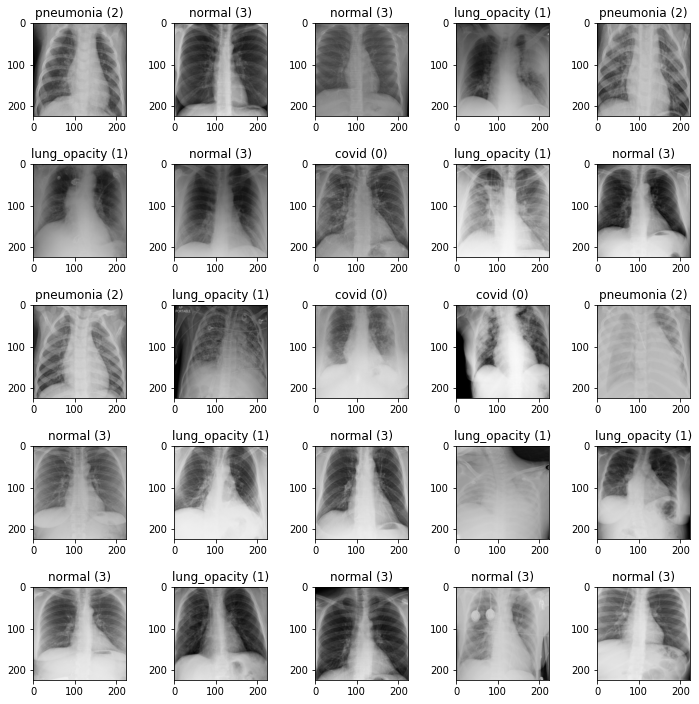

In [ ]:
show_batch(train_data, 5, 5)

### Calculate the means and standard deviation

We should calculate the means and standard deviation for all of our training dataset, for Normalization. It will improve our accuracy

In [ ]:
# initialize means and stds(3 channel)
means = np.array([0] * 3, dtype = float)
stds = np.array([0] * 3, dtype = float)

In [ ]:
cnt_progress = 0
total = len(train_data)
bar=progressbar.ProgressBar(maxval=total)
for (img, _) in train_data:
    for i in range(3): 
        means[i] += np.mean(np.array(img).transpose([2, 0, 1])[i]) / 255
        stds[i] += np.std(np.array(img).transpose([2, 0, 1])[i]) / 255

    cnt_progress+=1
    bar.update(cnt_progress)
bar.finish()
means /= total
stds /= total
print('means:', means)
print('stds:', stds)

100% (20215 of 20215) |##################| Elapsed Time: 0:01:18 Time:  0:01:18


means: [0.55006141 0.55006141 0.55006141]
stds: [0.17962446 0.17962446 0.17962446]


### Change Labels (Dataset `MyDataset`)

Because the initial corresponding results are wrong at this task, We wrote a custom dataset `MyDataset` to swap the labels generated by`imageFolder` (2 <-> 3)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]

        if self.transform:
            x = self.transform(x)
            
        if y == 2:
            return x, 3
        elif y == 3:
            return x, 2
        else:
            return x, y
        
    def __len__(self):
        return len(self.subset)

### Random split the train data

Becaue number of the images in train folder is too large, we can randomly select images in train folder. By calling `random_split` function to complete this task

In [ ]:
seed = 42
torch.manual_seed(seed);
# this range is from 0 to 1. It defines
split_ratio = 1   
# splite the 70% of all training data, if you want full, just enter 1
train_splite_num = int(len(train_data)*split_ratio)
train_ignore_num = len(train_data) - train_splite_num

train_splite, train_ignore = random_split(train_data, [train_splite_num, train_ignore_num])

test1_splite_num = int(len(train_ignore) * 0.05)
data_ignore_num = len(train_ignore) - test1_splite_num
test1_subDs, data_ignore = random_split(train_ignore, [test1_splite_num, data_ignore_num])

validation_num = int(len(train_splite)*0.1)
train_num = len(train_splite) - validation_num
train_subDs, validation_subDs = random_split(train_splite, [train_num, validation_num])

train_dataset_size = len(train_data)

print('Number of training:', len(train_subDs))
print('Number of validation:', len(validation_subDs))
print('Number of testing:', len(test1_subDs))

Number of training: 18194
Number of validation: 2021
Number of testing: 0


### Define transformations

In [ ]:
# define the augmentation for initialize the training set and validation set
train_transform = tt.Compose([
    # tt.ToPILImage(), 
    tt.RandomHorizontalFlip(0.5),
    tt.CenterCrop((224, 224)), # resize the pictures
    tt.ToTensor(),
    tt.Normalize(means, stds)
])

val_transform = tt.Compose([
    # tt.ToPILImage(), 
    tt.CenterCrop((224, 224)),
    tt.ToTensor(),
    tt.Normalize(means, stds)
])
test_transform = tt.Compose([
    # tt.ToPILImage(), 
    tt.CenterCrop((224, 224)),
    tt.ToTensor(),
    tt.Normalize(means, stds)
])

#### Other guesss of Data Augmentation

Because of time limitation and the performance score in our test not shown big improvement. We did not try this in our final model. But in theory, we think this transformation improves our model. This guess work for 299*299 train_subDs.

In [ ]:
guess_train_transform = tt.Compose([
        tt.RandomResizedCrop(224), #random zoom in
        tt.CenterCrop(224),
        tt.RandomHorizontalFlip(),# random flip
        tt.RandomRotation(10), # random rotate
        tt.ToTensor(),
    ])

In [ ]:
train_subDs = MyDataset(train_subDs, train_transform)
validation_subDs = MyDataset(validation_subDs, val_transform)
if split_ratio != 1:
    test1_subDs = MyDataset(test1_subDs, val_transform)

A image after normalization:

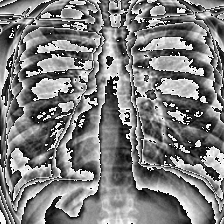

In [ ]:
tt.ToPILImage()(train_subDs[500][0])

Before normalization it looks like:

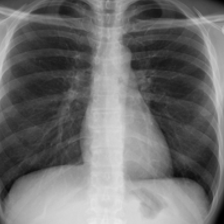

In [ ]:
train_subDs.subset.dataset[train_subDs.subset.indices[500]][0]

# Final model

In [ ]:
lr=1e-3
momentum=0.5
weight_decay=1e-2
n_epochs=40
epoch_start = 0
batch_size = 128
accuracy_score_type = 'normal'

## Train the model

In [ ]:
def train(model, optimizer, criterion, data_loader, accuracy_score_type = 'normal'):
    """
    Train the model with provided training data.
    ---
    model: the neutral network
    optimizer: it is used to update the weight parameters
    criterion: it is used to calculate the loss
    data_loader: the training dataloader
    accuracy_score_type: the default is normal, we can choose 'normal' or
                'f1_score' to compute accuracy_score or compute F1_score
    """
    model.train()   # the model is in the training mode so the parameters(weights)to be optimised will be updated
    train_loss, train_accuracy, cnt_progress = 0, 0, 0  # initialise loss and accuracy to 0 for training
        
    for X, y in data_loader: # iterate over the mini-batches defined in the data loader
        X, y = X.to(device), y.to(device)   # send data to the device (GPU in our case)
        optimizer.zero_grad()               # resetting optimiser info
        a2 = model(X.view(-1, 3, 224, 224))   # forward pass
        loss = criterion(a2, y)        # compute loss
        loss.backward()              # backpropagation to calculate the gradients
        train_loss += loss*X.size(0)   # add it up for different mini-batches and undo loss normalisation
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions

        if accuracy_score_type == 'normal':
            train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy_score
        elif accuracy_score_type == 'f1_score':
            train_accuracy += f1_score(y.cpu().numpy(), y_pred.detach().cpu().numpy(), average = 'macro') * X.size(0) # compute F1_score
            
        optimizer.step()  # perform a step of gradient descent
        cnt_progress += X.size(0)
        bar.update(cnt_progress)
            
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)   # here we can average over the whole dataset

# does not need optimiser
def validate(model, criterion, data_loader, accuracy_score_type = 'normal'):
    """
    Test the model with provided validation data.
    ---
    model: the neutral network
    optimizer: it is used to update the weight parameters
    criterion: it is used to calculate the loss
    data_loader: the training dataloader
    accuracy_score_type: the default is normal, we can choose 'normal' or
                'f1_score' to compute accuracy_score or compute F1_score
    """
    model.eval()            # model is set to evaluation mode so no dropout or any other funny stuff here
    validation_loss, validation_accuracy, cnt_progress = 0, 0, bar.value # initialise loss and accuracy to 0 for training
    for X, y in data_loader:   # iterate over the mini-batches defined in the data loader
        with torch.no_grad():  # deactivates autograd engine
            X, y = X.to(device), y.to(device)   # send data to the device (GPU in our case)
            a2 = model(X.view(-1, 3, 224, 224))   # forward pass
            loss = criterion(a2, y)    # evaluate loss
            validation_loss += loss*X.size(0)    # add it up for different mini-batches and undo loss normalisation
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]   # get predictions
            if accuracy_score_type == 'normal':
                validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy_score
            elif accuracy_score_type == 'f1_score':
                validation_accuracy += f1_score(y.cpu().numpy(), y_pred.detach().cpu().numpy(), average = 'macro') * X.size(0) # compute F1_score
                
            cnt_progress += X.size(0)
            bar.update(cnt_progress)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset
  
def evaluate_roc_auc_score(model, data_to_test):
    model = model.to(device)
    pred_matrix = np.zeros((len(data_to_test), 4))
    y_true = np.zeros(len(data_to_test))
    cnt_progress = 0
    bar=progressbar.ProgressBar(maxval=len(data_to_test))
    for i in range(len(data_to_test)):
        tensor = data_to_test[i][0].to(device)
        y_true[i] = data_to_test[i][1]
        tensor = tensor.reshape(1,3,224,224)
        out = model(tensor)
        y_pred_prob = F.softmax(out, dim=1)
        pred_matrix[i] = y_pred_prob.detach().cpu().numpy()
        cnt_progress+=1
        bar.update(cnt_progress)
    bar.finish()

    test_accuracy = roc_auc_score(y_true, np.array(pred_matrix), labels = np.array([0,1,2,3]), multi_class='ovr')
            
    return test_accuracy  ## return the multi-class roc_auc_score

def evaluate(model, data_loader):
    '''
    simply returns all predictions on a given dataset
    ---
    model: the neutral network
    data_loader: the training dataloader
    '''
    model.eval()
    ys, y_preds, y_probs = [], [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1,3, 224,224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            y_prob = F.softmax(a2, dim=1)
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            y_probs.append(y_prob.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0), np.concatenate(y_probs, 0).T

In [ ]:
def train_model(model, 
                momentum=0.5,
                betas=(0.9, 0.999),
                eps=1e-08,
                weight_decay=1e-2, 
                lr=1e-3, 
                n_epochs=10,
                epoch_start = 0, 
                batch_size=64, 
                test_batch_size=1000, 
                accuracy_score_type = 'normal',
                optimizer_type = 'SGD'
                ):
    '''
    Train the model with training dataset and validate dataset.
    ------
    model:         the neutral network
    momentum:        the parameter that helps accelerate optimizer
    betas:         a parameter for Adam algorithm
    eps:          similmar to above, a parameter for Adam algorithm
    weight_deacy:     the parameter of L2-Regularization
    lr:          the learning rate of optimizer
    n_epochs:       the number of epochs
    epoch_start:      the start number of epochs
    batch_size:      the batch size of training set
    test_batch_size:    the batch size of validation and test sets
    accuracy_score_type : type of accuracy metric of sklearn; 'normal' for accuracy_score, 'f1_score' for f1_score
    optimizer_type : 'SGD' for Stochastic Gradient Descant algorithm, 'Adam' for Adam algorithm.
    '''
    set_seed(42)
        
    model = model.to(device)
    if optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
    
    criterion = nn.CrossEntropyLoss()
    

    train_loader = DataLoader(train_subDs, batch_size=batch_size, shuffle=True, num_workers=0)  # train_loader
    validation_loader = DataLoader(validation_subDs, batch_size=test_batch_size, shuffle=False, num_workers=0) # validation_loader
    
    # Plot
    liveloss = PlotLosses()
    for epoch in range(epoch_start, epoch_start + n_epochs):
        print("epoch " + str(epoch) + " starting:")

        bar=progressbar.ProgressBar(maxval=len(train_subDs) + len(validation_subDs))

        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()
        
        bar.finish()
        liveloss.update(logs)
        liveloss.draw()

    return model

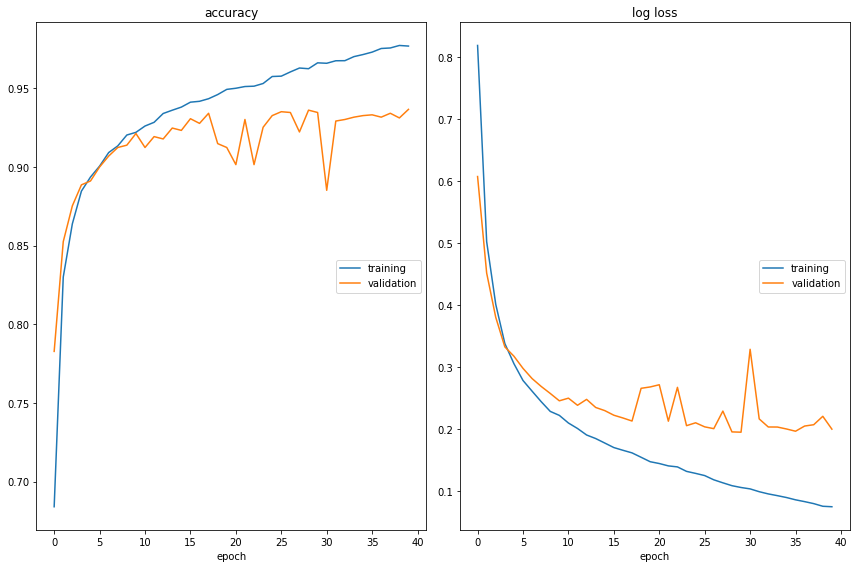

accuracy
	training         	 (min:    0.684, max:    0.977, cur:    0.977)
	validation       	 (min:    0.783, max:    0.937, cur:    0.937)
log loss
	training         	 (min:    0.075, max:    0.819, cur:    0.075)
	validation       	 (min:    0.195, max:    0.608, cur:    0.200)


In [ ]:
resnet18 = models.resnet18(pretrained=True).to(device)
fc_in = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_in, 4).to(device)
print(resnet18.fc)

fname = "Resnet18_new.pth"

resnet18 = train_model(resnet18, batch_size = batch_size, lr=lr, momentum=momentum, weight_decay=weight_decay, n_epochs=n_epochs, accuracy_score_type = accuracy_score_type)

## Save the model

In [ ]:
def save_model(model, model_save_name):
    '''
    Save model as pth file
    ---
    model: the neutral network
    model_save_name: the define file name

    '''
    path = F"/content/gdrive/MyDrive/acse4/{model_save_name}_sd.pth" 
    torch.save({
            'model_state_dict': model.state_dict(),
            'lr':lr,
            'momentum': momentum,
            'weight_decay':weight_decay,
            'epoch_start':n_epochs + epoch_start,
            'batch_size':batch_size,
            }, path)
    torch.save(model, F"/content/gdrive/MyDrive/acse4/{model_save_name}.pth") 

In [ ]:
os.chdir("/content/gdrive/MyDrive/acse4/")
model_save_name = "Resnet18_2005_3"
save_model(resnet18, model_save_name)
print("Model %s saved (epoch: %s)" % (model_save_name, epoch_start + n_epochs + 1))

Model Resnet18_2005_3.pth saved (epoch: 41)


## Load the model

In [ ]:
# load my model
os.chdir("/content/gdrive/MyDrive/acse4/")
# load your model 
net = torch.load('./Resnet18_2005_3.pth')
net = net.to(device)
# change back to sample data for work on data set
os.chdir("/content/sample_data")

## Evaluation Metrics For Multi-class Classification

In [ ]:
validation_loader = DataLoader(validation_subDs, batch_size=1000, shuffle=False, num_workers=0) # validation_loader
y_pred,y_test, y_prob=evaluate(net, validation_loader)

### Precision (P)

In [ ]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives

def true_positive(y_true, y_pred):
    '''
    Compute the true positives
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image

    '''
    
    tp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 1:
            tp += 1
    
    return tp

def true_negative(y_true, y_pred):
    '''
    Compute the true negative
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image

    '''
    
    tn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 0:
            tn += 1
            
    return tn

def false_positive(y_true, y_pred):
    '''
    Compute the False Positives
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image

    '''
    fp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 1:
            fp += 1
            
    return fp

def false_negative(y_true, y_pred):
    '''
    Compute the False negatives
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image
    '''
    fn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 0:
            fn += 1
            
    return fn

In [ ]:
#Computation of macro-averaged precision

def macro_precision(y_true, y_pred):
    '''
    Compute the macro-averaged precision
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image
    '''

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize precision to 0
    precision = 0
    
    # loop over all classes
    for class_ in list(np.unique(y_test)):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
        
    # calculate and return average precision over all classes
    precision /= num_classes
    
    return precision

In [ ]:
print(f"Macro-averaged Precision score : {macro_precision(y_test, y_pred) }")

Macro-averaged Precision score : 0.942823772203654


In [ ]:
def micro_precision(y_true, y_pred):
    '''
    Compute the micro_precision
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image

    '''


    # find the number of classes 
    num_classes = len(np.unique(y_true))
    
    # initialize tp and fp to 0
    tp = 0
    fp = 0
    
    # loop over all classes
    for class_ in np.unique(y_true):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        # calculate true positive for current class
        # and update overall tp
        tp += true_positive(temp_true, temp_pred)
        
        # calculate false positive for current class
        # and update overall tp
        fp += false_positive(temp_true, temp_pred)
        
    # calculate and return overall precision
    precision = tp / (tp + fp)
    return precision


In [ ]:
print(f"Micro-averaged Precision score : {micro_precision(y_test, y_pred)}")

Micro-averaged Precision score : 0.9366650173181593


### Recall

In [ ]:
#Computation of macro-averaged recall

def macro_recall(y_true, y_pred):
    '''
    Compute the macro-averaged recall
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image

    '''

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize recall to 0
    recall = 0
    
    # loop over all classes
    for class_ in list(np.unique(y_true)):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        
        # keep adding recall for all classes
        recall += temp_recall
        
    # calculate and return average recall over all classes
    recall /= num_classes
    
    return recall

In [ ]:
print(f"Macro-averaged recall score : {macro_recall(y_test, y_pred)}")

Macro-averaged recall score : 0.9394363925171378


In [ ]:
def micro_recall(y_true, y_pred):
    '''
    Compute the micro-averaged recall
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image

    '''


    # find the number of classes 
    num_classes = len(np.unique(y_true))
    
    # initialize tp and fp to 0
    tp = 0
    fn = 0
    
    # loop over all classes
    for class_ in np.unique(y_true):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        # calculate true positive for current class
        # and update overall tp
        tp += true_positive(temp_true, temp_pred)
        
        # calculate false negative for current class
        # and update overall tp
        fn += false_negative(temp_true, temp_pred)
        
    # calculate and return overall recall
    recall = tp / (tp + fn)
    return recall

In [ ]:
print(f"Micro-averaged recall score : {micro_recall(y_test, y_pred)}")

Micro-averaged recall score : 0.9366650173181593


### F1 score

In [ ]:
#Computation of macro-averaged fi score

def macro_f1(y_true, y_pred):
    '''
    Compute the macro-averaged fi score
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image

    '''

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize f1 to 0
    f1 = 0
    
    # loop over all classes
    for class_ in list(np.unique(y_true)):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        
        
        temp_f1 = 2 * temp_precision * temp_recall / (temp_precision + temp_recall + 1e-6)
        
        # keep adding f1 score for all classes
        f1 += temp_f1
        
    # calculate and return average f1 score over all classes
    f1 /= num_classes
    
    return f1

In [ ]:
print(f"Macro-averaged f1 score : {macro_f1(y_test, y_pred)}")

Macro-averaged f1 score : 0.9409263959170044


In [ ]:
def micro_f1(y_true, y_pred):
    '''
    Compute the micro-averaged fi score
    ---
    y_true:    The true label of the image
    y_pred:    The prediction label of the image

    '''
    #micro-averaged precision score
    P = micro_precision(y_true, y_pred)

    #micro-averaged recall score
    R = micro_recall(y_true, y_pred)

    #micro averaged f1 score
    f1 = 2*P*R / (P + R)    

    return f1
print(f"Micro-averaged recall score : {micro_f1(y_test, y_pred)}")

Micro-averaged recall score : 0.9366650173181593


### ROC-AUC (competition)

In [ ]:
def roc_auc_score_classes(actual_class, pred_class, pred_prob, average="macro"):
    '''
    Compute the roc_auc_score
    ---
    actual_class: The true label of the image
    pred_class:  The prediction label of the image
    pred_prob:   It is the probability, which can be obtained from evaluate function
    average:   It is equal to macro

    '''
    unique_class = set(actual_class)
    fprs = []
    tprs = []
    roc_auc_dict={}
    for per_class in unique_class:
        # creating a list of all the classes except the current class
        other_class =[x for x in unique_class if x!=per_class]
    
        new_actual_class=[0 if x in other_class else 1 for x in actual_class]
        new_pred_class=[0 if x in other_class else 1 for x in pred_class]
    
        roc_auc = roc_auc_score(new_actual_class, new_pred_class,average=average)

        fpr, tpr, _ = roc_curve(new_actual_class, pred_prob[per_class])
        fprs.append(fpr)
        tprs.append(tpr)

        roc_auc_dict[per_class] = roc_auc
    return roc_auc_dict, fprs, tprs

In [ ]:
roc_auc_dict, fprs, tprs = roc_auc_score_classes(y_test,y_pred, y_prob)
roc_auc_dict

{0: 0.9659344016198855,
 1: 0.9359802190038855,
 2: 0.9801418439716313,
 3: 0.9452631144041536}

### ROC curve Plot
An example from website, the closer the curve lies on the left-up corner, the preciser our model is.
![](https://glassboxmedicine.files.wordpress.com/2019/02/roc-curve-v2.png?w=576)

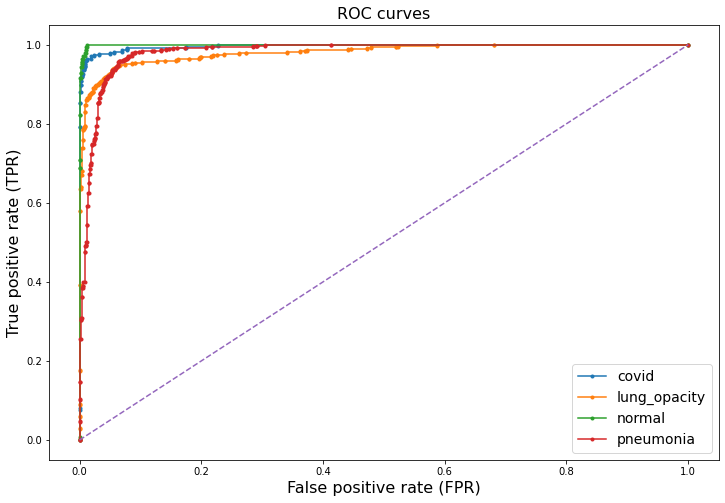

In [ ]:
# set up figure
labels = ['covid', 'lung_opacity', 'normal', 'pneumonia']
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.set_ylabel('True positive rate (TPR)', fontsize=16)
axs.set_xlabel('False positive rate (FPR)', fontsize=16)
axs.set_title('ROC curves', fontsize=16)
for i in range(4):
    axs.plot(fprs[i], tprs[i], '.-', label=labels[i])

axs.plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), '--' )
axs.legend(loc='best', fontsize=14)

### Confusion Matrix

In [ ]:
from pycm import ConfusionMatrix as ConfusionMatrix
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred)

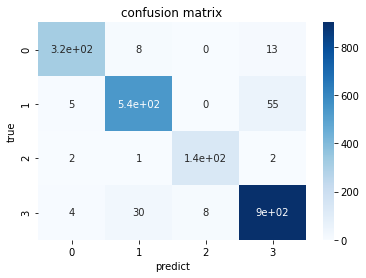

In [ ]:
import seaborn as sns

def to_raw_matrix(cm):
    '''
    Generate the confusion matrix
    ---
    cm:   the type of ConfusionMatrix

    '''
    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    return plt_cm

rcm = to_raw_matrix(cm) #store the confusion matrix values
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(rcm, cmap="Blues", annot=True)
ax.set_title('confusion matrix')
ax.set_xlabel('predict') 
ax.set_ylabel('true') 
plt.show()

# Model analysis






In [ ]:
print('Accuracy')
print(cm.ACC)

Accuracy
{0: 0.9841662543295399, 1: 0.9510143493320139, 2: 0.9935675408213755, 3: 0.9445818901533894}


**Accuracy** is the most straightforward evaluation for our model.

we can find that our model performance best on diagnose pneumonia and covid-19, with 99.3% and 98.4% accuracy. And with 94% probability to recognize rate is ok. We can bear this low rate because we can use other method such as waiting two more days to find disease symptoms to split the normal person from patient.

In [ ]:
print('False positive/type 1 error/false alarm')
print(cm.FP)
print(cm.FPR)

False positive/type 1 error/false alarm
{0: 11, 1: 39, 2: 8, 3: 70}
{0: 0.006547619047619024, 1: 0.027368421052631597, 2: 0.004255319148936176, 3: 0.06493506493506496}


In [ ]:
print('The patient be diagnosed as normal people rate:')
print('{0:', 13/(320+8+13),'1:', 55/(1+5+536+55),'2:', 2/(2+2+1+136+2),'}')

The patient be diagnosed as normal people rate:
{0: 0.03812316715542522 1: 0.09212730318257957 2: 0.013986013986013986 }


**The patient be diagnosed as normal people rate and False positive rate** are also important for our model because it is a medical image classification model. They are similar meanings. It is important to reduce False positive rate.

We have known that COVID-19 is the most hard control and dangerous disease right now, compared with pneumonia and lung_opacity then through our training we choose the model with higher accuracy and low FP rate model.

In [ ]:
print('False negative/miss/type 2 error')
print(cm.FN)
print(cm.FNR)

False negative/miss/type 2 error
{0: 21, 1: 60, 2: 5, 3: 42}
{0: 0.061583577712609916, 1: 0.10067114093959728, 2: 0.03546099290780147, 3: 0.044538706256627814}


In [ ]:
print('Precision or positive predictive value')
print(cm.PPV)

Precision or positive predictive value
{0: 0.9667673716012085, 1: 0.9321739130434783, 2: 0.9444444444444444, 3: 0.9279093717816684}


**Precision criteria and false negative** rate are less important compared with accuracy and Recall(FP) rate, but it need to be check when we choose our model. They also have similar meanings.

The model with high FN and low precision will not consider to be the best model at last.

In [ ]:
print('Sensitivity, recall, hit rate, or true positive rate')
print(cm.TPR)

TPR(Sensitivity, recall, hit rate, or true positive rate)
{0: 0.9384164222873901, 1: 0.8993288590604027, 2: 0.9645390070921985, 3: 0.9554612937433722}


**Tips**: We do not use the recall be the key index of our model. Because we only concern about the covid-19 peitient be diagnosed as normal people. If they are diagnosed be other patient we can have manually method to solve( such as do test again for every patients).

You can check more information and evaluation parameters with print

In [ ]:
#print(cm)

# Working on competition
## Load model for predicting on test sets

### Load test data

In [ ]:
os.chdir("/content/sample_data")
test_data  = ImageFolder(test_dir,  transform=init_transform)

### Get the indexies of test set from `Imagefolder`

In [ ]:
# return the index of test sets
def testset_imgs_to_index(test_data):
    '''
    get the index of test sets
    ---
    test_data:   the test data

    '''
    length = len(test_data)
    index = np.zeros(length, dtype=int)
    for i in range(len(test_data)):
        path = str(test_data.imgs[i][0])
        index[i] = re.split(r'[._]',path)[2]
    return index

In [ ]:
index_testset = testset_imgs_to_index(test_data)
# check
print(index_testset[0:10])

[  0   1  10 100 101 102 103 104 105 106]


### Calculate the means and standard derivations for all of our test dataset, for Normalization:

In [ ]:
# initialize means and stds(3 channel)
means = np.array([0] * 3, dtype = float)
stds = np.array([0] * 3, dtype = float)

In [ ]:
cnt_progress = 0
total = len(test_data)
bar=progressbar.ProgressBar(maxval=total)
for (img, _) in test_data:
    for i in range(3): 
        means[i] += np.mean(np.array(img).transpose([2, 0, 1])[i]) / 255
        stds[i] += np.std(np.array(img).transpose([2, 0, 1])[i]) / 255

    cnt_progress+=1
    bar.update(cnt_progress)
bar.finish()
means /= total
stds /= total
print('means:', means)
print('stds:', stds)

100% (950 of 950) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


means: [0.54999396 0.54999396 0.54999396]
stds: [0.1813238 0.1813238 0.1813238]


In [ ]:
test_transform = tt.Compose([
    tt.CenterCrop((224, 224)),
    tt.ToTensor(),
    tt.Normalize(means, stds)
])

In [ ]:
os.chdir("/content/sample_data")
test_data  = ImageFolder(test_dir,  transform=test_transform)

### load model for predicting on test sets

In [ ]:
os.chdir("/content/sample_data")
total = len(test_data)
cnt_progress = 0

# initialize label list
output_labels=np.zeros(total)

bar=progressbar.ProgressBar(maxval=total)

for i in range(len(test_data)):
    tensor = test_data[i][0].to(device)
    tensor = tensor.reshape(1,3,224,224)
    output=net(tensor)
    _, pred = torch.max(output.data,1)
    test_index = index_testset[i]
    output_labels[test_index] = (pred.item())
    cnt_progress+=1
    bar.update(cnt_progress)
bar.finish()

100% (950 of 950) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


### output csv, save at `/content/gdrive/MyDrive/acse4` (run this cell two times may be)

You might need run two times to produce the .csv file.

In [ ]:
import csv
os.chdir("/content/gdrive/MyDrive/acse4")
output_name = "prediction.csv"

f = open(output_name,'w',encoding='utf-8')
csv_writer = csv.writer(f)
csv_writer.writerow(["name","target"])

for i in range(950):
    name_tmp = "test_" + str(i)
    target_tmp = str(output_labels[i])
    csv_writer.writerow([name_tmp, target_tmp])